In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'
from classy import Class

#sys.path.append('/home/joeadamo/Research/Software')
#sys.path.append('/home/joeadamo/Research/Software')
#from pk_tools import pk_tools
sys.path.insert(1, '/home/joeadamo/Research/CovNet')
#sys.path.insert(1, "/users/JoeyA/Research/CovNet")
import src as CovNet
import src.CovaPT as CovaPT

In [2]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
train_gaussian_only = False

architecture = "MLP"
device = CovNet.try_gpu()

#base_dir = "/Users/JoeyA/Research/"
base_dir = "/home/joeadamo/Research/"
training_dir = base_dir+"CovNet/Data/Training-Set-HighZ-NGC/"
save_dir = base_dir+"CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/Updated/"
CovaPT_dir = base_dir+'CovaPT/Data/'

folder=architecture+"/"

net_dir_VAE = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/VAE/"
net_dir_AE  = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/AE/"
net_dir_MLP = base_dir+"CovNet/emulators/ngc_z3/MLP/"
#net_dir_MLP = base_dir+"CovNet/emulators/ngc_z3/MLP-backup/"
net_dir_T = base_dir+"CovNet/emulators/ngc_z3/MLP-T/"
net_dir_PCA = base_dir+"CovNet/emulators/ngc_z3/MLP-PCA/"

net_dir_VAE_G = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/VAE-gaussian/"
net_dir_AE_G  = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/AE-gaussian/"
net_dir_MLP_G = base_dir+"/CovNet/emulators/ngc_z3/MLP-gaussian/"
net_dir_T_G = base_dir+"/CovNet/emulators/ngc_z3/MLP-T-gaussian/"

In [3]:
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_heatmap(params, data, label, extents, cmap, log_scale):
    names = ['omch2', 'H0', "As", "b1", "b2", "bG2", "chi_squared"]
    labels= [r'$\omega_{cdm}$', r"$H_0$", r"$A_s$", "$b1$", "$b2$", "$bG2$", label]
        
    params = params.copy()
    temp = params[:,1].copy()
    params[:,1] = params[:,0].copy()
    params[:,0] = temp
    fig, axs = plt.subplots(6,6, figsize=(14,14))
    for i in range(6):
        for j in range(6):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], data, 30)
                #axs[i][j].axhline(0, color="red")
                axs[i][j].plot(x, y)
                #axs[i][j].set_ylim(-0.3, 0.3)
                #axs[i][j].set_yscale("log")
            else:
                X, Y, Z = make_heatmap(params[:,j], params[:,i], data, 30)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.SymLogNorm(linthresh=1., vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                # if log_scale == True: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, alpha=0.8, cmap=cmap,
                #                                               norm=colors.SymLogNorm(vmin=extents[0], vmax=extents[1], linthresh=1))
                # else: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, vmin=extents[0], vmax=extents[1], alpha=0.8, cmap=cmap)
            if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
            axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1] ,size=20)
    cbar.ax.tick_params(labelsize=15) 
    plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

In [4]:
# load the test set
t1 = time.time()
test_data     = CovNet.MatrixDataset(training_dir, "testing", 1., train_gaussian_only=False)
gaussian_data = CovNet.MatrixDataset(training_dir, "testing", 1., train_gaussian_only=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 7.54 s


In [5]:
# load the trained networks

net_MLP = CovNet.Network_Emulator("MLP").to(device);       net_MLP.eval()
net_MLP.load_state_dict(torch.load(net_dir_MLP+'network.params', map_location=torch.device('cpu')))

net_PCA = CovNet.Network_Emulator("MLP-PCA").to(device);    net_PCA.eval()
net_PCA.load_state_dict(torch.load(net_dir_PCA+'network.params', map_location=torch.device('cpu')))
# net_VAE = CovNet.Network_Emulator("VAE").to(device);       net_VAE.eval()
# net_VAE.load_state_dict(torch.load(net_dir_VAE+'network-VAE.params', map_location=torch.device('cpu')))
# encoder_VAE = CovNet.Blocks.Block_Encoder("VAE").to(device);            encoder_VAE.eval()
# decoder_VAE = CovNet.Blocks.Block_Decoder("VAE").to(device);      decoder_VAE.eval()
# encoder_VAE.load_state_dict(net_VAE.Encoder.state_dict())
# decoder_VAE.load_state_dict(net_VAE.Decoder.state_dict())
# net_latent_VAE = CovNet.Blocks.Network_Latent().to(device)
# net_latent_VAE.load_state_dict(torch.load(net_dir_VAE+'network-latent.params', map_location=torch.device('cpu')))

patch_size=torch.Tensor([17,5]).int()
num_blocks = 5
num_heads = 5
net_T = CovNet.Network_Emulator("MLP-T", 0., num_blocks, patch_size, num_heads, True).to(device);       net_T.eval()
net_T.load_state_dict(torch.load(net_dir_T+'network.params', map_location=torch.device('cpu')))
    
#Cov_Emulator_VAE = CovNet.CovNet(net_dir_VAE, 50, 0)
Cov_Emulator_T = CovNet.Emulator.CovNet(net_dir_T, 50, "MLP-T", num_blocks=num_blocks, patch_size=patch_size, num_heads=num_heads)
Cov_Emulator_MLP = CovNet.Emulator.CovNet(net_dir_MLP, 50, "MLP")
Cov_Emulator_PCA = CovNet.Emulator.CovNet(net_dir_PCA, 50, "MLP-PCA")
pca = Cov_Emulator_PCA.pca
min_v, max_v = Cov_Emulator_PCA.pca_min_values, Cov_Emulator_PCA.pca_max_values

# Cov_Emulator_VAE_G = CovNet.CovNet(net_dir_VAE_G, 50, 0)
# Cov_Emulator_AE_G = CovNet.CovNet(net_dir_AE_G, 50, 3)
Cov_Emulator_MLP_G = CovNet.Emulator.CovNet(net_dir_MLP_G, 50, "MLP")
Cov_Emulator_T_G = CovNet.Emulator.CovNet(net_dir_T_G, 50, "MLP-T", num_blocks=5, patch_size=torch.Tensor([17,5]).int(), num_heads=5)

In [6]:
# get the number of trainable parameters
#total_params_VAE = sum(p.numel() for p in net_VAE.parameters() if p.requires_grad)
#total_params_VAE += sum(p.numel() for p in net_latent_VAE.parameters() if p.requires_grad)

total_params_T = sum(p.numel() for p in net_T.parameters() if p.requires_grad)

total_params_MLP = sum(p.numel() for p in net_MLP.parameters() if p.requires_grad)

#print("VAE network has   {:0.0f} trainable parameters".format(total_params_VAE))
print("MLP network has   {:0.0f} trainable parameters".format(total_params_MLP))
print("MLP-T network has {:0.0f} trainable parameters".format(total_params_T))

MLP network has   6197900 trainable parameters
MLP-T network has 6644235 trainable parameters


final MLP validation loss = 5.737
final MLP gaussian validation loss = 0.622


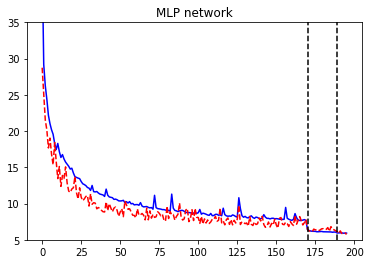

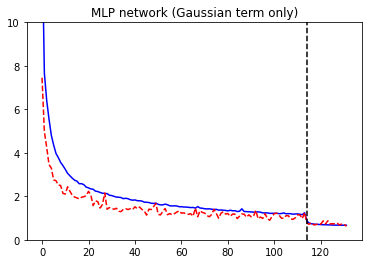

In [7]:
# visualize the training and validation loss

# MLP network
training_data = torch.load("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-backup/train_data.dat", map_location=CovNet.try_gpu())

epochs = training_data[0,:]    
round_start = torch.where(epochs == 0)[0]
train_loss = training_data[1,:]
valid_loss = training_data[2,:]

print("final MLP validation loss = {:0.3f}".format(torch.min(valid_loss)))

#fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.title("MLP network")
plt.plot(range(len(epochs)), train_loss, color="blue", label="training loss")
plt.plot(range(len(epochs)), valid_loss, color="red", ls="--", label="validation loss")
plt.ylim(5, 35)
for i in range(1, len(round_start)):
    plt.axvline(round_start[i], c="black", ls="--")

# MLP Gaussian Network
training_data_G = torch.load("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-gaussian/train_data.dat", map_location=CovNet.try_gpu())

epochs_G = training_data_G[0,:]    
round_start_G = torch.where(epochs_G == 0)[0]
train_loss_G = training_data_G[1,:]
valid_loss_G = training_data_G[2,:]

print("final MLP gaussian validation loss = {:0.3f}".format(torch.min(valid_loss_G)))

#fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.figure()
plt.title("MLP network (Gaussian term only)")
plt.plot(range(len(epochs_G)), train_loss_G, color="blue", label="training loss")
plt.plot(range(len(epochs_G)), valid_loss_G, color="red", ls="--", label="validation loss")
plt.ylim(0, 10)
for i in range(1, len(round_start_G)):
    plt.axvline(round_start_G[i], c="black", ls="--")

final MLP validation loss = 4.688
final MLP validation loss = 0.446


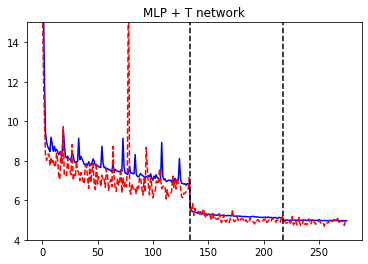

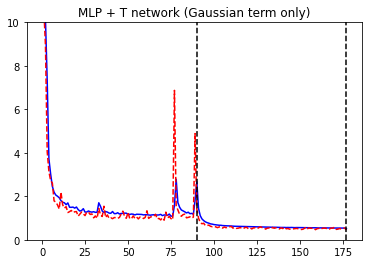

In [8]:
# Transformer network
training_data = torch.load("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-T/train_data.dat", map_location=CovNet.try_gpu())

epochs = training_data[0,:]    
round_start = torch.where(epochs == 0)[0]
train_loss = training_data[1,:]
valid_loss = training_data[2,:]

print("final MLP validation loss = {:0.3f}".format(torch.min(valid_loss)))

#fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.title("MLP + T network")
plt.plot(range(len(epochs)), train_loss, color="blue", label="training loss")
plt.plot(range(len(epochs)), valid_loss, color="red", ls="--", label="validation loss")
plt.ylim(4, 15)

for i in range(1, len(round_start)):
    plt.axvline(round_start[i], c="black", ls="--")
    
training_data = torch.load("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-T-gaussian/train_data.dat", map_location=CovNet.try_gpu())
epochs = training_data[0,:]    
round_start = torch.where(epochs == 0)[0]
train_loss = training_data[1,:]
valid_loss = training_data[2,:]

print("final MLP validation loss = {:0.3f}".format(torch.min(valid_loss)))

#fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.figure()
plt.title("MLP + T network (Gaussian term only)")
plt.plot(range(len(epochs)), train_loss, color="blue", label="training loss")
plt.plot(range(len(epochs)), valid_loss, color="red", ls="--", label="validation loss")
plt.ylim(0, 10)

for i in range(1, len(round_start)):
    plt.axvline(round_start[i], c="black", ls="--")

In [9]:
# # generate plots of best loss with respect to varied hyperparameters

# for net_dir in [net_dir_VAE, net_dir_MLP, net_dir_T]:
#     if net_dir == net_dir_VAE:   label="VAE network"
#     elif net_dir == net_dir_T:  label="MLP-T network"
#     elif net_dir == net_dir_MLP: label="MLP network"
    
#     if exists(net_dir+"optimized-lr.dat"):
#         lr_loss_dat = torch.load(net_dir+"optimized-lr.dat", map_location=CovNet.try_gpu())

#         lr = torch.logspace(-4, -2, 20)
#         bsize = torch.Tensor([25, 50, 100, 200, 265, 424, 530])

#         lr = lr[(lr_loss_dat[0,:] != 0)]
#         if architecture != 2: lr_VAE = lr_loss_dat[1,:][(lr_loss_dat[0,:] != 0)]
#         lr_loss = lr_loss_dat[0,:][(lr_loss_dat[0,:] != 0)]

#         idx_best = torch.argmin(lr_loss)
#         print("best learning rate: {:0.3e}".format(lr[idx_best]))
#         print("best loss achieved: {:0.3f}".format(lr_loss[idx_best]))

#         plt.figure()
#         plt.scatter(lr, lr_loss, c="black")
#         plt.scatter(lr[idx_best], lr_loss[idx_best], c="blue")
#         if architecture != 2: plt.scatter(lr, lr_VAE, c="red")
#         plt.title(label)
#         plt.xlabel("learning rate")
#         plt.ylabel("Best validation loss")
#         plt.xscale("log")
#         plt.ylim(8, 50)

#     if exists(net_dir+"optimized-bsize.dat"):
#         bsize_loss_dat = torch.load(net_dir+"optimized-bsize.dat", map_location=CovNet.try_gpu())

#         bsize = bsize[(bsize_loss_dat[0,:] != 0)]
#         if architecture != 2: bsize_VAE = bsize_loss_dat[1,:][(bsize_loss_dat[0,:] != 0)]
#         bsize_loss = bsize_loss_dat[0,:][(bsize_loss_dat[0,:] != 0)]

#         plt.figure()
#         plt.scatter(bsize, bsize_loss, c="black")
#         plt.xlabel("batch size")

In [10]:
# # try to visualize the latent feature space
# features_encoder_VAE = torch.zeros(N_test, 6, device=CovNet.try_gpu())
# #features_encoder_AE = torch.zeros(N_test, 6, device=CovNet.try_gpu())
# features_latent_VAE = torch.zeros(N_test, 6, device=CovNet.try_gpu())
# #features_latent_AE = torch.zeros(N_test, 6, device=CovNet.try_gpu())

# for i in tqdm(range(N_test)):
#     matrix = test_data[i][1]
#     params = test_data[i][0]
#     z, mu_VAE, log_var = encoder_VAE(matrix.view(1, 50, 50))
#     features_encoder_VAE[i] = mu_VAE.detach()
#     features_latent_VAE[i] = net_latent_VAE(params).detach()
#     # z, mu_AE, log_var = encoder_AE(matrix.view(1, 50, 50))
#     # features_encoder_AE[i] = z.detach()
#     # features_latent_AE[i] = net_latent_AE(params).detach()

# features_encoder_VAE = features_encoder_VAE.to("cpu").detach().numpy()
# features_latent_VAE = features_latent_VAE.to("cpu").detach().numpy()
# # features_encoder_AE = features_encoder_AE.to("cpu").detach().numpy()
# # features_latent_AE = features_latent_AE.to("cpu").detach().numpy()

In [11]:
# N_colors = 6 # <- number of colors
# base = plt.cm.get_cmap("jet")
# color_list = base(np.linspace(0, 1, N_colors))
# cmap_name = base.name + str(N)
# cmap = base.from_list(cmap_name, color_list, N_colors)

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# f1 = 1; f2 = 2; f3 = 3
# plt.suptitle("from encoder")
# axs[0].scatter(features_encoder_VAE[:,f1], features_encoder_VAE[:,f2], cmap=cmap, c=features_encoder_VAE[:,f3], alpha=0.8, s=1)
# #axs[1].scatter(features_encoder_AE[:,f1], features_encoder_AE[:,f2], cmap=cmap, c=features_encoder_AE[:,f3], alpha=0.8, s=1)
# axs[0].set_xlabel("1st feature")
# axs[0].set_ylabel("2nd feature")
# axs[0].set_xlim(np.amin(features_encoder_VAE[:,f1])-0.1, np.amax(features_encoder_VAE[:,f1])+0.1)
# #axs[1].set_xlim(np.amin(features_encoder_AE[:,f1])-0.1, np.amax(features_encoder_AE[:,f1])+0.1)
# axs[0].set_ylim(np.amin(features_encoder_VAE[:,f2])-0.1, np.amax(features_encoder_VAE[:,f2])+0.1)
# #axs[1].set_ylim(np.amin(features_encoder_AE[:,f2])-0.1, np.amax(features_encoder_AE[:,f2])+0.1)
# # cbar = plt.colorbar()
# # cbar.set_label("3rd feature")

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# plt.suptitle("from secondary network")
# axs[0].scatter(features_latent_VAE[:,f1], features_latent_VAE[:,f2], cmap=cmap, c=features_latent_VAE[:,f3], alpha=0.8, s=1)
# #axs[1].scatter(features_latent_AE[:,f1], features_latent_AE[:,f2], cmap=cmap, c=features_latent_AE[:,f3], alpha=0.8, s=1)
# axs[0].set_xlabel("1st feature")
# axs[0].set_ylabel("2nd feature")
# axs[0].set_xlim(np.amin(features_encoder_VAE[:,f1])-0.1, np.amax(features_encoder_VAE[:,f1])+0.1)
# #axs[1].set_xlim(np.amin(features_encoder_AE[:,f1])-0.1, np.amax(features_encoder_AE[:,f1])+0.1)
# axs[0].set_ylim(np.amin(features_encoder_VAE[:,f2])-0.1, np.amax(features_encoder_VAE[:,f2])+0.1)
# #axs[1].set_ylim(np.amin(features_encoder_AE[:,f2])-0.1, np.amax(features_encoder_AE[:,f2])+0.1)
# # cbar = plt.colorbar()
# # cbar.set_label("3rd feature")

# features_diff_sub_VAE = (features_latent_VAE - features_encoder_VAE) / (np.amax(features_encoder_VAE, axis=0) - np.amin(features_encoder_VAE, axis=0))
# #features_diff_sub_AE = (features_latent_AE - features_encoder_AE) / (np.amax(features_encoder_AE, axis=0) - np.amin(features_encoder_AE, axis=0))

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# for i in range(6):
#     axs[0].scatter(1+np.ones(N_test)*i, features_diff_sub_VAE[:,i], c="black", s=0.5)
#     #axs[1].scatter(1+np.ones(N_test)*i, features_diff_sub_AE[:,i], c="black", s=0.5)
    
# axs[0].axhspan(-0.1, 0.1, color="blue", alpha=0.2)
# axs[1].axhspan(-0.1, 0.1, color="blue", alpha=0.2)
# axs[0].set_ylabel(r"$z_{encoder} - z_{latent net}$")
# axs[1].set_ylabel(r"$z_{encoder} - z_{latent net}$")

# features_diff_VAE = np.linalg.norm(features_latent_VAE - features_encoder_VAE, axis=1) / np.linalg.norm(features_encoder_VAE, axis=1)
# #features_diff_AE = np.linalg.norm(features_latent_AE - features_encoder_AE, axis=1) / np.linalg.norm(features_encoder_AE, axis=1)

# num_1 = len(features_diff_VAE[(features_diff_VAE < 0.1)])
# #num_2 = len(features_diff_AE[(features_diff_AE < 0.1)])
# print("{:0.0f} VAE test matrices ({:0.3f}%) have fractional latent-space distance errors less than 10%".format(num_1, (100.*num_1)/N_test))
# #print("{:0.0f} AE test matrices ({:0.3f}%) have fractional latent-space distance errors less than 10%".format(num_2, (100.*num_2)/N_test))

# # params = test_data[:][0].detach().numpy().copy()
# # params[:,2]*=3.0447
# # plot_heatmap(params, features_diff, r"$\frac{|z_{encoder} - z_{latent\ net}|}{|z_{encoder}|}$", [0.05, 0.25], "viridis", False)

In [14]:
# get a bunch of statistics from the test set and the matrices output by the emulator
N_test = len(test_data)
loss_data = np.zeros((N_test, 3))

det_actual = np.zeros((N_test, 1))
det_reconstruct = np.zeros(N_test)
det_predict = np.zeros((N_test, 3))

trace_actual = np.zeros((N_test, 1))
trace_reconstruct = np.zeros(N_test)
trace_predict = np.zeros((N_test, 3))

cond_actual = np.zeros((N_test, 1))
cond_predict = np.zeros((N_test, 3))

num_NaN = np.zeros(3)
num_unstable = np.zeros(3)

components = net_PCA(test_data[:][0]).view(N_test, 250)
C_PCA = CovNet.Dataset.reverse_pca(components, pca, min_v, max_v)

for i in tqdm(range(N_test)):
    params = test_data[i][0]
    C_actual = test_data[i][1]
    
    # get the loss that is internally calculated by the training algorithm
    components = net_PCA(params.view(1,6)).view(250)
    #C_predict_1_PCA = CovNet.Dataset.reverse_pca(components, pca, min_v, max_v).view(50,50)
    C_predict_PCA = C_PCA[i]
    C_predict_1_T = net_T(params.view(1, 6)).view(50,50)
    C_predict_1_MLP = net_MLP(params.view(1, 6)).view(50,50)
        
    if True in torch.isnan(C_predict_1_PCA): num_NaN[0] += 1
    if True in torch.isnan(C_predict_1_T): num_NaN[1] += 1
    if True in torch.isnan(C_predict_1_MLP): num_NaN[2] += 1
    
    loss_data[i, 0] = F.l1_loss(C_predict_1_PCA, C_actual, reduction="sum")
    loss_data[i, 1] = F.l1_loss(C_predict_1_T, C_actual, reduction="sum")
    loss_data[i, 2] = F.l1_loss(C_predict_1_MLP, C_actual, reduction="sum")

    # C_predict_1_MLP = CovNet.symmetric_exp(C_predict_1_MLP, 5.91572, 4.62748).view(50,50)
    # C_predict_1_MLP = C_predict_1_MLP.detach().numpy().astype(np.float64)
    # C_predict_1_MLP = np.matmul(C_predict_1_MLP, C_predict_1_MLP.T)
    
    C_predict_PCA = CovNet.symmetric_exp(C_predict_1_PCA, 5.91572, 4.62748).view(50,50)
    C_predict_PCA = C_predict_PCA.detach().numpy().astype(np.float64)
    C_predict_PCA = np.matmul(C_predict_PCA, C_predict_PCA.T)
    
    # now get the loss of the full covariance matrix (after un-doing data pre-processing
    C_actual = test_data.get_full_matrix(i)
    #C_predict_PCA = Cov_Emulator_PCA.get_covariance_matrix(params.detach().numpy())
    C_predict_T = Cov_Emulator_T.get_covariance_matrix(params.detach().numpy())
    C_predict_MLP = Cov_Emulator_MLP.get_covariance_matrix(params.detach().numpy())
    # sanity check that I'm using the emulator correctly
    
    #assert np.allclose(C_predict_MLP, C_predict_1_MLP)
        
    det_actual[i] = np.linalg.slogdet(C_actual)[1]
    #det_reconstruct[i] = np.linalg.slogdet(C_reconstruct)[1]
    det_predict[i, 0] = np.linalg.slogdet(C_predict_PCA)[1]
    det_predict[i, 1] = np.linalg.slogdet(C_predict_T)[1]
    det_predict[i, 2] = np.linalg.slogdet(C_predict_MLP)[1]
    
    trace_actual[i] = np.trace(C_actual)
    #trace_reconstruct[i] = np.trace(C_reconstruct)
    trace_predict[i, 0] = np.trace(C_predict_PCA)
    trace_predict[i, 1] = np.trace(C_predict_T)
    trace_predict[i, 2] = np.trace(C_predict_MLP)
    
    cond_actual[i] = np.linalg.cond(C_actual)
    cond_predict[i, 0] = np.linalg.cond(C_predict_PCA)
    cond_predict[i, 1] = np.linalg.cond(C_predict_T)
    cond_predict[i, 2] = np.linalg.cond(C_predict_MLP)
    
    if cond_predict[i,0] > 1e9: num_unstable[0]+=1
    if cond_predict[i,1] > 1e9: num_unstable[1]+=1
    if cond_predict[i,2] > 1e9: num_unstable[2]+=1
    
print("MLP-T: min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data[:,1]), np.amax(loss_data[:,1]), np.mean(loss_data[:,1])))
print("MLP:   min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data[:,2]), np.amax(loss_data[:,2]), np.mean(loss_data[:,2])))
print("PCA:   min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data[:,0]), np.amax(loss_data[:,0]), np.mean(loss_data[:,0])))
print(num_NaN, "matrices have NaNs")
print(num_unstable, "matrices have very high condition numbers")

100%|█████████████████████████████████████| 65872/65872 [14:45<00:00, 74.36it/s]

MLP-T: min loss: 0.243, max loss 454.416, avg loss: 4.960
MLP:   min loss: 0.248, max loss 1093.108, avg loss: 6.228
PCA:   min loss: 23.150, max loss 914.474, avg loss: 194.211
[0. 0. 0.] matrices have NaNs
[ 0. 58. 67.] matrices have very high condition numbers


MLP-T loss error summary stats: mean = 4.960, median = 1.890, std = 10.699
MLP loss error summary stats:   mean = 6.228, median = 2.203, std = 26.818
PCA loss error summary stats:   mean = 194.211, median = 192.654, std = 62.630

MLP-T trace error summary stats: mean = 261.945, median = -0.004, std = 11994.528
MLP trace error summary stats:   mean = 17.205, median = 0.004, std = 706.373
PCA trace error summary stats:   mean = 12.205, median = 2.043, std = 22.787

MLP-T determinant error summary stats: mean = 1.119e-04, median = 2.060e-04, std = 0.004
MLP determinant error summary stats:   mean = 1.065e-03, median = 5.989e-04, std = 0.016
PCA determinant error summary stats:   mean = 0.102, median = 0.165, std = 0.235


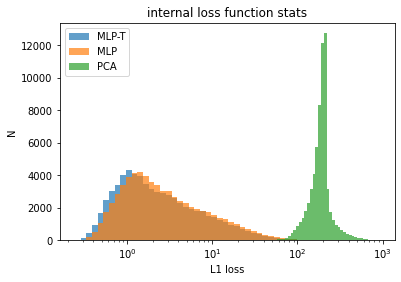

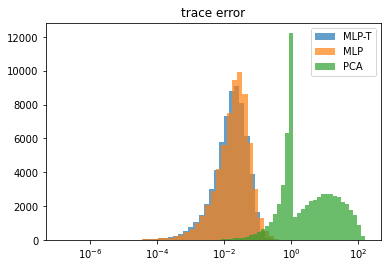

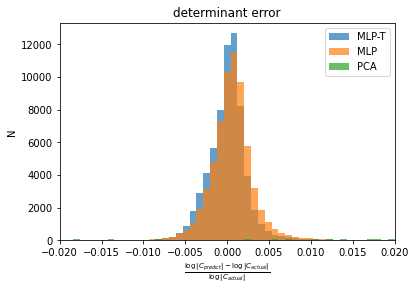

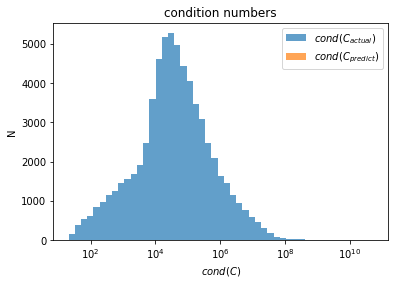

In [15]:
# these plots are mainly just for diagnostic purposes - not for showing other people
# because aparently they are too confusing
plt.title("internal loss function stats")

plt.hist(loss_data[:,1], alpha=0.7, label="MLP-T", bins=np.logspace(np.log10(np.amin(loss_data[:,1])), np.log10(np.amax(loss_data[:,1])), 50))
plt.hist(loss_data[:,2], alpha=0.7, label="MLP", bins=np.logspace(np.log10(np.amin(loss_data[:,1])), np.log10(np.amax(loss_data[:,1])), 50))
plt.hist(loss_data[:,0], alpha=0.7, label="PCA", bins=np.logspace(np.log10(np.amin(loss_data[:,0])), np.log10(np.amax(loss_data[:,0])), 50))

plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
plt.xscale("log")

trace_diff = (trace_predict - trace_actual) / trace_actual
trace_diff_T = trace_diff[:,1][(cond_predict[:,1] < 1e9)]
trace_diff_MLP = trace_diff[:,2][(cond_predict[:,2] < 1e9)]
trace_diff_PCA = trace_diff[:,0][(cond_predict[:,0] < 1e9)]
#print(trace_diff[:,1])

plt.figure()
plt.title("trace error")
#plt.hist(abs(trace_diff_1), alpha=0.7, label="matrix -> latent -> matrix", bins=np.logspace(np.log10(np.amin(abs(trace_diff_1))), np.log10(abs(np.amax(trace_diff_1))), 50))
plt.hist(abs(trace_diff_T), alpha=0.7, label="MLP-T", bins=np.logspace(np.log10(np.amin(abs(trace_diff_T))), np.log10(np.amax(trace_diff_T)), 50))
plt.hist(abs(trace_diff_MLP), alpha=0.7, label="MLP", bins=np.logspace(np.log10(np.amin(abs(trace_diff_MLP))), np.log10(np.amax(trace_diff_MLP)), 50))
plt.hist(abs(trace_diff[:,0]), alpha=0.7, label="PCA", bins=np.logspace(np.log10(np.amin(abs(trace_diff_PCA))), np.log10(np.amax(trace_diff_PCA)), 50))
plt.xscale("log")
plt.legend()

det_diff = (det_predict - det_actual) / det_actual
#det_diff = det_diff[(cond_predict < 1e9)]

num = len(loss_data[(abs(loss_data) <= 10)])
print("MLP-T loss error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data[:,1]), np.median(loss_data[:,1]), np.std(loss_data[:,1])))
print("MLP loss error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data[:,2]), np.median(loss_data[:,2]), np.std(loss_data[:,2])))
print("PCA loss error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data[:,0]), np.median(loss_data[:,0]), np.std(loss_data[:,0])))

#print("{:0d} ({:0.2f}%) of matrices have loss better than 10!".format(num, 100.*num/N_test))

#num = len(trace_diff_2[(abs(trace_diff_2) <= 0.1)])
print("\nMLP-T trace error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(trace_diff[:,1]), np.median(trace_diff[:,1]), np.std(trace_diff[:,1])))
print("MLP trace error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(trace_diff[:,2]), np.median(trace_diff[:,2]), np.std(trace_diff[:,2])))
print("PCA trace error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(trace_diff[:,0]), np.median(trace_diff[:,0]), np.std(trace_diff[:,0])))
#print("{:0d} ({:0.2f}%) of matrices have trace errors better than 10%!".format(num, 100.*num/N_test))

#num = len(det_diff_2[(abs(det_diff_2) <= 0.01)])
print("\nMLP-T determinant error summary stats: mean = {:0.3e}, median = {:0.3e}, std = {:0.3f}".format(np.mean(det_diff[:,1]), np.median(det_diff[:,1]), np.std(det_diff[:,1])))
print("MLP determinant error summary stats:   mean = {:0.3e}, median = {:0.3e}, std = {:0.3f}".format(np.mean(det_diff[:,2]), np.median(det_diff[:,2]), np.std(det_diff[:,2])))
print("PCA determinant error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(det_diff[:,0]), np.median(det_diff[:,0]), np.std(det_diff[:,0])))

#print("{:0d} ({:0.2f}%) of matrices have log determinant errors better than 1%!".format(num, 100.*num/N_test))

plt.figure()
plt.title("determinant error")
#plt.hist(det_diff_1, alpha=0.7, label="matrix -> latent -> matrix", bins=np.linspace(np.amin(det_diff_1), np.amax(det_diff_1), 50))
plt.hist(det_diff[:,1], alpha=0.7, label="MLP-T", bins=np.linspace(-0.02, 0.02, 50))
plt.hist(det_diff[:,2], alpha=0.7, label="MLP", bins=np.linspace(-0.02, 0.02, 50))
plt.hist(det_diff[:,0], alpha=0.7, label="PCA", bins=np.linspace(-0.02, 0.02, 50))
plt.xlabel(r"$\frac{\log{|C_{predict}|} - \log{|C_{actual}|}}{\log{|C_{actual}|}}$")
plt.ylabel("N")
plt.xlim(-0.02, 0.02)
plt.legend()

plt.figure()
plt.title("condition numbers")
plt.hist(cond_actual, alpha=0.7, label=r"$cond(C_{actual})$", bins=np.logspace(np.log10(np.amin(cond_actual)), np.log10(np.amax(cond_actual)), 50))
plt.hist(cond_predict[:,1], alpha=0.7, label=r"$cond(C_{predict})$", bins=np.logspace(np.log10(np.amin(cond_predict[:,0])), np.log10(np.amax(cond_predict[:,0])), 50))
plt.xlabel(r"$cond(C)$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

In [ ]:
# do the same thing for the gaussian emulators
loss_data_G = np.zeros((len(gaussian_data), 3))
 
for i in tqdm(range(len(gaussian_data))):
    params = gaussian_data[i][0]
    C_actual = gaussian_data[i][1]
    
    #C_predict_VAE = Cov_Emulator_VAE_G.get_covariance_matrix(params.detach().numpy(), raw=True).view(50,50)
    C_predict_T = Cov_Emulator_T_G.get_covariance_matrix(params.detach().numpy(), raw=True).view(50,50)
    C_predict_MLP = Cov_Emulator_MLP_G.get_covariance_matrix(params.detach().numpy(), raw=True).view(50,50)
    
    #C_predict_VAE = CovNet.symmetric_log(torch.linalg.cholesky(C_predict_VAE))
    #C_predict_AE = CovNet.symmetric_log(torch.linalg.cholesky(C_predict_AE))
    #C_predict_MLP = CovNet.symmetric_log(torch.linalg.cholesky(C_predict_MLP))
    
    loss_data_G[i, 1] = F.l1_loss(C_predict_T, C_actual, reduction="sum")
    loss_data_G[i, 2] = F.l1_loss(C_predict_MLP, C_actual, reduction="sum")
    #loss_data_G[i, 0] = min(loss_data_G[i, 1], loss_data_G[i, 1])
    
#print("VAE: min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_G[:,0]), np.amax(loss_data_G[:,0]), np.mean(loss_data_G[:,0])))
print("MLP-T:  min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_G[:,1]), np.amax(loss_data_G[:,1]), np.mean(loss_data_G[:,1])))
print("MLP: min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_G[:,2]), np.amax(loss_data_G[:,2]), np.mean(loss_data_G[:,2])))
#print("combined: min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_G[:,0]), np.amax(loss_data_G[:,0]), np.mean(loss_data_G[:,0])))

MLP-T loss error summary stats: mean = 0.452, median = 0.200, std = 1.098
MLP loss error summary stats:   mean = 0.620, median = 0.320, std = 0.839


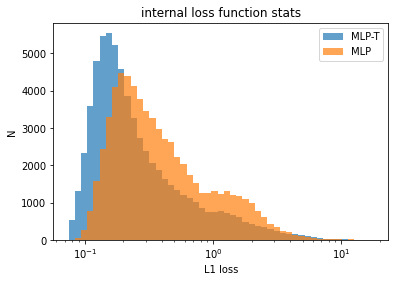

In [54]:
print("MLP-T loss error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data_G[:,1]), np.median(loss_data_G[:,1]), np.std(loss_data_G[:,1])))
print("MLP loss error summary stats:   mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data_G[:,2]), np.median(loss_data_G[:,2]), np.std(loss_data_G[:,2])))

plt.title("internal loss function stats")

#plt.hist(loss_data_G[:,0], alpha=0.7, label="combined", bins=np.logspace(np.log10(np.amin(loss_data_G[:,0])), np.log10(np.amax(loss_data_G[:,0])), 50))
plt.hist(loss_data_G[:,1], alpha=0.7, label="MLP-T", bins=np.logspace(np.log10(np.amin(loss_data_G[:,2])), np.log10(np.amax(loss_data_G[:,2])), 50))
plt.hist(loss_data_G[:,2], alpha=0.7, label="MLP", bins=np.logspace(np.log10(np.amin(loss_data_G[:,2])), np.log10(np.amax(loss_data_G[:,2])), 50))
plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
plt.xscale("log")

In [51]:
# params = test_data[:][0].detach().numpy().copy()
# params[:,2]*=3.0447
# params = params[(cond_predict < 1e9)]
# plot_heatmap(params, trace_diff_2, r"$\frac{tr(C_{emulator}) - tr(C_{actual})}{tr(C_{actual})}$", [-0.5, 0.5], "BrBG", False)

In [ ]:
plot_heatmap(params, det_diff_2, r"$\frac{\log(|C_{emulator}|) - \log(|C_{actual}|)}{\log(|C_{actual}|)}$", [-0.04, 0.04], "RdBu", False)

In [ ]:
params = test_data[:][0].detach().numpy().copy()
params[:,2]*=3.0447
plot_heatmap(params, cond_predict, r"$cond(C_{predict})$", [1e2, 1e8], "inferno", True)

In [ ]:
# # get the chi squared differences using this network
# # This cell takes ~ 2 hours to run the first time, 
# chi_squared_predict = np.zeros(N_test)
# chi_squared_actual = np.zeros(N_test)
# non_definete = []; avg_bad = 0
# x_fixed = data_vector - model_vector_fixed
# for i in tqdm(range(N_test)):
#     params = test_data[i][0].detach().numpy()
#     C_actual = test_data.get_full_matrix(i)
#     C_predict_1 = Cov_Emulator_1.get_covariance_matrix(params) 
    
#     #model_vector = get_model_vector(params, i, int(N*0.9))
    
#     P_predict_1 = np.linalg.inv(C_predict_1)
#     P_actual = np.linalg.inv(C_actual)
    
#     #x = data_vector - model_vector
#     chi_squared_actual[i] = np.matmul(x_fixed.T, np.matmul(P_actual, x_fixed))
#     chi_squared_predict[i] = np.matmul(x_fixed.T, np.matmul(P_predict_1, x_fixed))
    
# chi_squared_err = chi_squared_predict - chi_squared_actual
# chi_squared_err = chi_squared_err[(chi_squared_actual >= 0)]
# chi_squared_valid = chi_squared_actual[(chi_squared_actual >= 0)]

In [ ]:
# chi_squared_rel_err = (chi_squared_predict - chi_squared_actual) / chi_squared_valid

# plt.figure()
# plt.hist(abs(chi_squared_rel_err), bins=np.logspace(np.log10(np.amin(abs(chi_squared_rel_err))), np.log10(np.amax(abs(chi_squared_rel_err))), 50))
# plt.xlabel(r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$")
# plt.ylabel("N")
# plt.xscale("log")

# num = len(chi_squared_rel_err[(abs(chi_squared_rel_err) <= 0.1)])
# print("'chi squared' error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(chi_squared_rel_err), np.median(chi_squared_rel_err), np.std(chi_squared_rel_err)))
# print("{:0d} ({:0.2f}%) of matrices have chi squared errors better than 10%!".format(num, 100.*num/N_test))

# params = test_data[:][0].detach().numpy().copy()
# params[:,2]*=3.0447
# plot_heatmap(params, chi_squared_rel_err, r"$\frac{\chi_{predict}^2 - \chi_{actual}^2}{\chi_{actual}^2}$", 
#              [-0.6, 0.6], "PiYG", False)

In [ ]:
#plot_heatmap(params, chi_squared_err, r"$\chi_{predict}^2 - \chi_{actual}^2$", [-1e4, 1e4], "viridis", True)

In [ ]:
# # visualize the total (chi squared + log determinat) likelihood error at each point in parameter space
# # if the error depends on your location in parameter space, that's not good!

# lkl_actual = chi_squared_actual + det_actual
# lkl_predict = chi_squared_predict + det_predict

# lkl_error = lkl_predict - lkl_actual
# lkl_rel_error = lkl_error / lkl_actual
# print(np.amin(lkl_rel_error), np.amax(lkl_rel_error))

# #plot_heatmap(params, lkl_error, r"$(-2 \ln \mathcal{L}_{predict}) - (-2\ln \mathcal{L}_{actual})$", [-1e2, 1e5], "viridis", True)

# plot_heatmap(params, lkl_rel_error, r"$\frac{(-2 \ln \mathcal{L}_{predict}) - (-2\ln \mathcal{L}_{actual})}{(-2\ln \mathcal{L}_{actual})}$",
#                      [-0.1, 0.3], "viridis", False)

In [ ]:
# do a PCA on the whole training set, treating each covariance matrix as a single realization
if architecture != 2:
    data_predict = np.zeros((N_test, 51*25))
    data_actual  = np.zeros((N_test, 51*25))
    data_random = np.zeros((N_test, 51*25))
    rand_idx = np.random.randint(0, N_test)

    min_val, max_val = 100, -100

    for i in tqdm(range(N_test)):
        params = test_data[i][0]
        C_actual = test_data[i][1].view(1,50,50)
        C_random = torch.rand(1, 50, 50) * (9.79 + 9.94) - 9.94
        C_predict = decoder(net_2(params).view(1,6)).view(1, 50, 50)

        C_predict = CovNet.rearange_to_half(C_predict, 50).detach().numpy()
        C_actual = CovNet.rearange_to_half(C_actual, 50).detach().numpy()
        C_random = CovNet.rearange_to_half(C_random, 50).detach().numpy()

        data_predict[i] = C_predict.flatten()
        data_actual[i] = C_actual.flatten()
        data_random[i] = C_random.flatten()

        min_val = min(min_val, np.amin(C_actual))
        max_val = max(max_val, np.amax(C_actual))

    print(min_val, max_val)
    pca = PCA(n_components = 100)
    # find the principal axes (basis vectors) of the testing set
    pca.fit(data_actual)
    # now project both the testing set and the prediced matrices set onto those basis vectors
    components_predict = pca.transform(data_predict)
    components_actual = pca.transform(data_actual)
    components_random = pca.transform(data_random)

In [ ]:
if architecture != 2:
    print(np.sum(pca.explained_variance_ratio_[:10]))
    PCA_diff = np.linalg.norm(components_predict - components_actual, axis=0)
    #PCA_diff = abs(np.sum(components_predict - components_actual, axis=0))
    rand_diff = np.linalg.norm(components_random - components_actual, axis=0)
    print(PCA_diff.shape)

    plt.scatter(components_actual[:, 0], components_actual[:, 1], s=2, label="actual")
    plt.scatter(components_predict[:, 0], components_predict[:, 1], s=2, alpha=0.8, label="predicted")
    plt.scatter(components_random[:, 0], components_random[:, 1], s=2, alpha=0.8, label="random")
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend()

    plt.figure()
    plt.bar(np.array(range(10))-0.2, PCA_diff[:10], width=0.4, label=r"|$PC_{actual} - PC_{predict}$|")
    plt.bar(np.array(range(10))+0.2, rand_diff[:10], width=0.4, label=r"|$PC_{actual} - PC_{random}$|")
    plt.xlabel("PC number")
    plt.ylabel("difference")
    plt.legend()
    #plt.yscale("log")

### Tests on individual matrices

Indexes: 240 5144


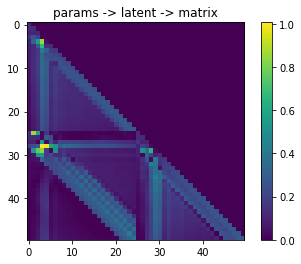

In [38]:
# Let's first confirm that seperate parameter imputs give different outputs
# if the resulting plot is all zeros, that may suggest posterior collapse of the network
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

architecture = 4

if architecture == 0 or architecture == 3:
    cov_reconstruct1, mu, var = net(cov_actual1.view(1,50,50))
    cov_reconstruct2, mu, var = net(cov_actual2.view(1,50,50))

    features = net_2(params1); cov_predict1 = decoder(features.view(1,6)).view(50, 50).to("cpu").detach()
    features_2 = net_2(params2); cov_predict2 = decoder(features_2.view(1,6)).view(50, 50).to("cpu").detach()
else:
    cov_predict1 = net_T(params1.view(1,6)).view(50,50).detach()
    cov_predict2 = net_T(params2.view(1,6)).view(50,50).detach()
    
# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.title("params -> latent -> matrix")
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

if architecture == 0 or architecture == 3:
    
    plt.figure()
    plt.title("matrix -> latent -> matrix")
    plt.imshow(abs(cov_reconstruct1 - cov_reconstruct2).view(50,50).detach().numpy())
    cbar = plt.colorbar()
    
    plt.figure()
    plt.scatter(range(6), features.view(6).detach().numpy())
    plt.scatter(range(6), features_2.view(6).detach().numpy())
    plt.xticks([0,1,2,3,4,5])
    plt.ylabel("latent space value")

sample 4621, params: tensor([ 7.2573e+01,  6.2184e-02,  1.1492e+00,  3.1205e+00, -3.6225e+00,
        -9.4916e-01])
Loss value = 40.246
det(C) = 619.90, actual = 620.044


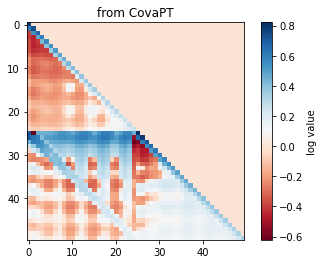

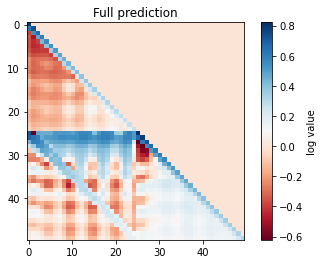

In [44]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
#idx = np.argmax(det_diff[:,1])
#idx = np.argmax(cond_predict[:,1])

#idx = 0
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = test_data[idx][1]
if architecture == 0 or architecture == 3:
    # matrix from VAE reconstruction
    cov_VAE, mu, log_var = net_T(cov_actual.view(1,50,50)); cov_VAE = cov_VAE.view(50,50)
    # matrix from parameters -> features and features -> matrix
    features = net_2(params); cov_predict = decoder(features.view(1,6)).view(50, 50)
    features_VAE, mu, log_var = encoder(cov_actual.view(1,50,50))

else:
    cov_predict = net_T(params.view(1,6)).view(50, 50)

RLoss = F.l1_loss(cov_predict, cov_actual, reduction="sum")
#KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2)) if architecture != 2 else 0

#print("reduction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
#cov_actual = CovNet.symmetric_exp(cov_actual)
# cov_VAE = CovNet.symmetric_exp(cov_VAE)
# cov_predict = CovNet.symmetric_exp(cov_predict)

print("Loss value = {:0.3f}".format(RLoss))

if architecture == 0 or architecture == 3: cov_VAE = cov_VAE.to("cpu").detach(); 
cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

#model_vector = get_model_vector(params.detach().numpy(), idx, int(N*0.9))
x = data_vector - model_vector_fixed
# chi_squared_pred = np.matmul(x.T, np.matmul(np.linalg.inv(CovNet.symmetric_exp(cov_predict).numpy()), x))
# chi_squared_act = np.matmul(x.T, np.matmul(np.linalg.inv(cov_actual.numpy()), x))

det_pred = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_predict, 5.91572, 4.62748).numpy())))
#det_rec = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_VAE, 5.91572, 4.62748).numpy()))) if architecture != 2 else 0
det_act = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_actual, 5.91572, 4.62748).numpy())))

print("det(C) = {:0.2f}, actual = {:0.3f}".format(det_pred, det_act))
#print("Chi squared = {:0.3f}, actual = {:0.3f}".format(chi_squared_pred, chi_squared_act))

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

if architecture == 0 or architecture == 3:
    plt.figure()
    plt.title("VAE reconstruction")
    plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
    cbar = plt.colorbar()
    cbar.set_label("log value")

plt.figure()
plt.title("Full prediction")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

if architecture == 0 or architecture == 3:
    features_lat = features.detach().numpy()
    features_VAE = features_VAE.detach().numpy()
    norm = np.linalg.norm(features_VAE - features_lat)
    norm_str = "{:0.3f}".format(norm)
    plt.figure()
    plt.title(r"$|z_{decoder} - z_{latent_net}| = $ " + norm_str)
    plt.plot(np.vstack([range(1,7), range(1,7)]), np.vstack([features_lat, features_VAE]), c="black")
    plt.scatter(range(1, 7), features_VAE, c="green", label="z from encoder")
    plt.scatter(range(1, 7), features_lat, c="red",label="z from latent network")
    plt.xticks([1,2,3,4,5,6])
    plt.legend()

trace(C) = 1.096e+10 (actual = 1.113e+10
det(C) = 619.90, actual = 620.044
cond(C) = 6.39e+06, actual = 6.67e+06


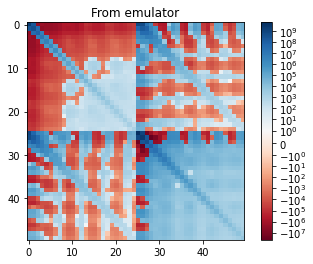

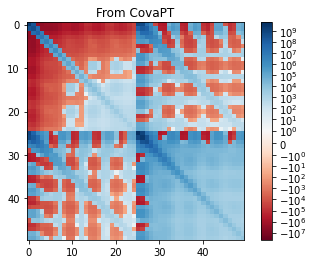

In [45]:
params = test_data[idx][0].detach().numpy()
C_actual = test_data.get_full_matrix(idx)
C_predict = Cov_Emulator_T.get_covariance_matrix(params)

trace_pred = np.trace(C_predict)
trace_act = np.trace(C_actual)

det_pred = np.linalg.slogdet(C_predict)[1]
det_act  = np.linalg.slogdet(C_actual)[1]

cond_pred = np.linalg.cond(C_predict)
cond_act = np.linalg.cond(C_actual)

print("trace(C) = {:0.3e} (actual = {:0.3e}".format(trace_pred, trace_act))
print("det(C) = {:0.2f}, actual = {:0.3f}".format(det_pred, det_act))
print("cond(C) = {:0.2e}, actual = {:0.2e}".format(cond_pred, cond_act))

plt.title("From emulator")
matrix = plt.imshow(C_predict, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_predict), vmax=np.amax(C_predict)))
plt.colorbar()

plt.figure()
plt.title("From CovaPT")
matrix = plt.imshow(C_actual, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_predict), vmax=np.amax(C_predict)))
plt.colorbar()

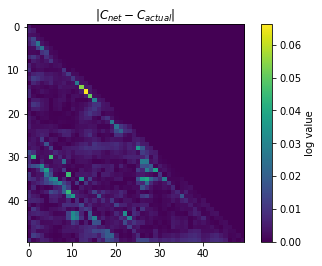

In [42]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

In [ ]:
# test that 2 different parameter lsits give 2 different matrices
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)

params1 = test_data[idx1][0]
params2 = test_data[idx2][0]
# matrix from CovaPT
cov_actual1 = test_data[idx1][1]
cov_actual2 = test_data[idx2][1]

# matrix from parameters -> features and features -> matrix
cov_predict1 = decoder_VAE(net_VAE(params1).view(1,6)).view(50, 50)
cov_predict2 = decoder_VAE(net_VAE(params2).view(1,6)).view(50, 50)

cov_predict1 = cov_predict1.to("cpu").detach().numpy()
cov_predict2 = cov_predict2.to("cpu").detach().numpy()

plt.title("")
plt.imshow(cov_predict1 - cov_predict2, cmap="RdBu")#, vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

### Test on individual Gaussian Matrix near the contours we're trying to emulate

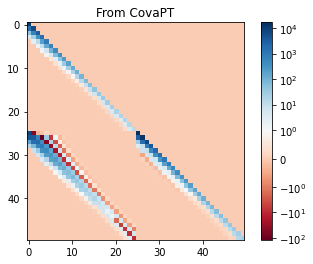

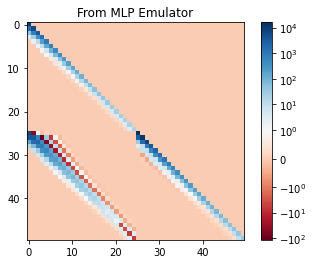

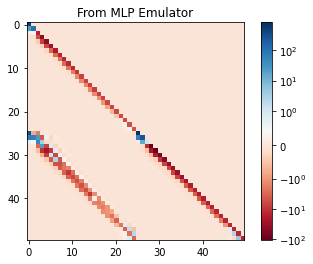

In [25]:
params_best = np.array([67.86, 9.9788e-2, 3.3382 / 3.0447, 1.7733, -3.2923, 9.321e-2])

Mat_Calc = CovNet.CovaPT.Analytic_Covmat(0.61)

C_CovaPT = Mat_Calc.get_gaussian_covariance(np.concatenate((params_best, [0.,0.,500., 0.])))
C_MLP = Cov_Emulator_MLP_G.get_covariance_matrix(params_best)

C_CovaPT = np.linalg.cholesky(C_CovaPT)
C_MLP = np.linalg.cholesky(C_MLP)

plt.figure()
plt.title("From CovaPT")
matrix = plt.imshow(C_CovaPT, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_CovaPT), vmax=np.amax(C_CovaPT)))
plt.colorbar()

plt.figure()
plt.title("From MLP Emulator")
matrix = plt.imshow(C_MLP, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_MLP), vmax=np.amax(C_MLP)))
plt.colorbar()

plt.figure()
plt.title("From MLP Emulator")
matrix = plt.imshow(C_CovaPT - C_MLP, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_CovaPT - C_MLP), vmax=np.amax(C_CovaPT - C_MLP)))
plt.colorbar()

## Extra tests for debugging

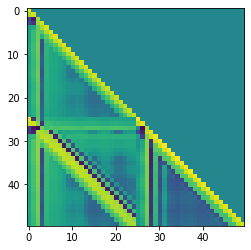

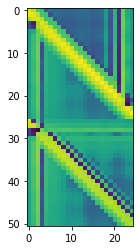

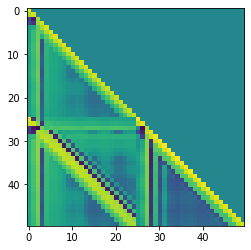

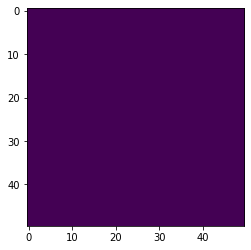

In [25]:
# test rearange to half / full code
idx1 = np.random.randint(0, N_test)

# matrix from CovaPT
cov_actual = test_data[idx1][1].view(1,50,50)

cov_half = CovNet.rearange_to_half(cov_actual, 50)

cov_full = CovNet.rearange_to_full(cov_half, 50, True)

# det_half = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_half), dim1=1, dim2=2))) + \
#            2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_half), offset=1, dim1=1, dim2=2)))
# det_full = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_full), dim1=1, dim2=2)))

# print(det_half, det_full)

plt.imshow(cov_actual.view(50,50).detach().numpy())

plt.figure()
plt.imshow(cov_half.view(51,25).detach().numpy())

plt.figure()
plt.imshow(cov_full.view(50,50).detach().numpy())

plt.figure()
plt.imshow((cov_full - cov_actual).view(50,50).detach().numpy())

torch.Size([85, 15])
tensor([[0., 1., 0.,  ..., 0., 1., 0.]])


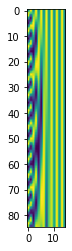

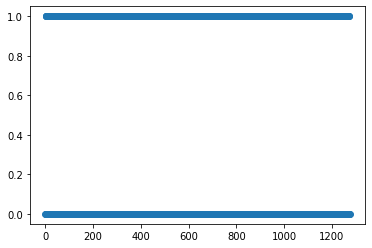

In [56]:
# test transformer functions

pos_embed = net_T.get_positional_embedding(int(51*25 / (3*5)), 3*5)
print(pos_embed.shape)

pos_embed_2 = net_T.get_positional_embedding(1, int(51*25))

plt.imshow(pos_embed)

print(pos_embed_2)

plt.figure()
plt.scatter(range(1275), pos_embed_2[0])

In [ ]:
full = torch.zeros((10,6))

temp1 = torch.ones((5, 6))
temp2 = torch.ones((5, 6))*3.

full[0:5, :] = temp1
full[5:10, :] = temp2

print(full)

test = test_data[0:50][1]
print(test.shape)

In [ ]:
# test that symmetric_log and symmetric_exp work on batches of matrices

test_batch = torch.ones((2, 50, 50))
test_batch[0] *= 10
test_batch[1] *= 100

test_batch = CovNet.symmetric_log(test_batch)
print(test_batch)
test_batch = CovNet.symmetric_exp(test_batch)
print(test_batch)

In [ ]:
patch_size = torch.Tensor([3, 5]).int()
N = torch.Tensor([51, 25]).int()
n_patches = (N / patch_size).int().tolist()
patch_size = patch_size.tolist()

def patchify(X):

    patches = X.unfold(1, patch_size[0], patch_size[0]).unfold(2, patch_size[1], patch_size[1])
    patches = patches.reshape(-1, n_patches[0]*n_patches[1], patch_size[0] * patch_size[1])
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

#X = torch.zeros(1, 51, 25)
X = torch.arange(0, 51*25).reshape(1, 51, 25).float()
X = patchify(X)
print(X.shape)
h1 = nn.Linear(15, 10)
tokens = h1(X)
print(tokens.shape)

class_token = nn.Parameter(torch.rand(1, 10))

pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
pos_embed.requires_grad = False

tokens = torch.stack([torch.vstack((class_token, tokens[i])) for i in range(len(tokens))])
print(tokens.shape)

In [ ]:
patch_size = torch.Tensor([3, 5]).int()
N = torch.Tensor([51, 25]).int()
n_patches = (N / patch_size).int().tolist()
patch_size = patch_size.tolist()

def patchify(X):

    X = X.reshape(-1, 51, 25)
    
    patches = X.unfold(1, patch_size[0], patch_size[0]).unfold(2, patch_size[1], patch_size[1])
    #patches = patches.reshape(-1, n_patches[0]*n_patches[1], patch_size[0] * patch_size[1])
    #patches = patches.reshape(-1, n_patches[1] * n_patches[0], patch_size[0], patch_size[1])
    patches = patches.reshape(-1, n_patches[1] * n_patches[0], patch_size[0]*patch_size[1])
    return patches

def reconstruct_image(patches):
    #patches = patches.reshape(-1, n_patches[1] * n_patches[0], patch_size[0], patch_size[1])

    patches = patches.reshape(n_patches[0], n_patches[1], patch_size[0], patch_size[1])

    unfolded = patches.permute(0, 2, 1, 3).contiguous()
    image = unfolded.view(-1, N[0], N[1])
    
    return image

X = torch.arange(0, 51*25)

print(X.shape)
X = patchify(X)
print(X.shape)

X = reconstruct_image(X)
print(X.shape)
print(X)

NameError: name 'num_blocks' is not defined

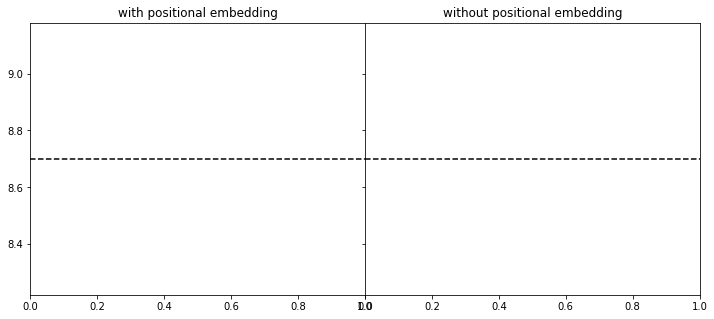

In [8]:
from matplotlib.lines import Line2D

num_sizes = 5
embedding = np.array([0, 1])

loss = np.array([[[11.965, 8.610], [8.189, 8.471], [8.292, 12.255], [8.320, 8.642], [8.168, 8.862], [8.132, 8.307]],
                 [[9.996, 9.675], [8.301, 8.750], [9.228, 8.193], [8.894, 8.274], [8.927, 8.420], [8.190, 9.070]],
                 [[8.348, 9.706], [8.221, 8.379], [9.602, 8.430], [8.355, 8.782], [8.133, 8.230], [8.153, 8.197]],
                 [[9.001, 8.123], [8.308, 8.404], [8.308, 8.231], [8.434, 8.356], [8.354, 8.472], [8.202, 8.819]],
                 [[8.182, 8.282], [8.124, 8.195], [8.368, 8.296], [8.215, 8.253], [8.287, 8.267], [8.046, 8.254]]])


colors = ["red", "orange", "green", "blue", "purple"]


fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplots_adjust(wspace=0)
ax[0].set_title("with positional embedding")
ax[1].set_title("without positional embedding")
ax[0].axhline(8.7, c="black", ls="--")
ax[1].axhline(8.7, c="black", ls="--")
for i in range(num_blocks):
    for j in range(num_sizes):
        
        ax[0].scatter(i+1, loss[j,i,0], c=colors[j], marker="o")
        ax[1].scatter(i+1, loss[j,i,1], c=colors[j], marker="x")

legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='[3, 5]', markersize=10),
                   Line2D([], [], c="w", label=""),
                   Line2D([0], [0], marker='o', color=colors[1], label='[3, 1]', markersize=10),
                   Line2D([], [], c="w", label=""),
                   Line2D([0], [0], marker='o', color=colors[2], label='[1, 5]', markersize=10),
                   Line2D([0], [0], ls="--", color="black", label="MLP Loss"),
                   Line2D([0], [0], marker='o', color=colors[3], label='[17, 5]', markersize=10),
                   Line2D([], [], c="w", label=""),
                   Line2D([0], [0], marker='o', color=colors[4], label='[17, 25]', markersize=10),
                   Line2D([], [], c="w", label="")]
ax[0].set_xlabel("number of blocks")
ax[1].set_xlabel("number of blocks")
ax[0].set_ylabel("minimum loss")
ax[0].set_ylim(8, 10)

ax[0].legend(handles=legend_elements, ncol=5, loc="lower center", bbox_to_anchor=(1., -0.27))

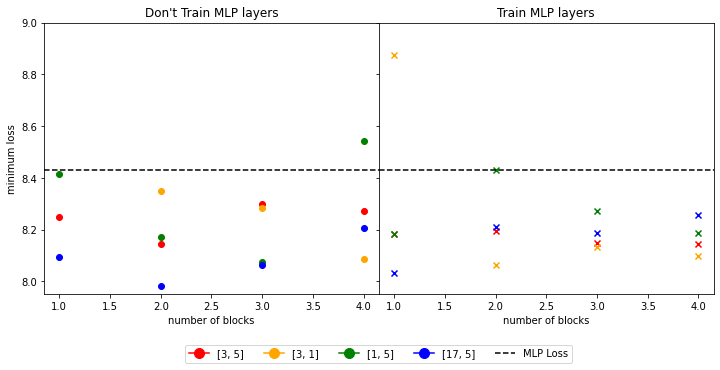

In [15]:
loss_data = np.array([[[8.323,8.250,8.184,8.304],[8.144,8.370,8.194,8.302],[8.301,8.469,8.147,8.816],[8.329,8.274,8.146,8.517]],
                      [[9.154,11.470,9.884,8.876],[8.348,8.467,8.064,8.645],[8.781,8.283,8.132,9.421],[8.085,8.202,8.097,8.315]],
                      [[8.417,8.708,8.570,8.185],[8.173,8.921,8.430,8.593],[8.076,8.323,8.400,8.273],[8.615,8.541,8.187,8.464]],
                      [[8.094,8.358,8.033,8.311],[8.011,7.984,8.209,8.300],[8.065,8.106,8.186,8.377],[8.222,8.207,8.256,8.356]]])

colors = ["red", "orange", "green", "blue", "purple"]

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplots_adjust(wspace=0)
ax[0].set_title("Don't Train MLP layers")
ax[1].set_title("Train MLP layers")
ax[0].axhline(8.43, c="black", ls="--")
ax[1].axhline(8.43, c="black", ls="--")
for i in range(4):
    for j in range(4):
        
        ax[0].scatter(i+1, min(loss_data[j,i,0], loss_data[j,i,1]), c=colors[j], marker="o")
        ax[1].scatter(i+1, min(loss_data[j,i,2], loss_data[j,i,3]), c=colors[j], marker="x")
        
legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='[3, 5]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[1], label='[3, 1]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[2], label='[1, 5]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[3], label='[17, 5]', markersize=10),
                   Line2D([0], [0], ls="--", color="black", label="MLP Loss")]

ax[0].set_xlabel("number of blocks")
ax[1].set_xlabel("number of blocks")
ax[0].set_ylabel("minimum loss")
ax[0].set_ylim(7.95, 9)

ax[0].legend(handles=legend_elements, ncol=5, loc="lower center", bbox_to_anchor=(1., -0.27))

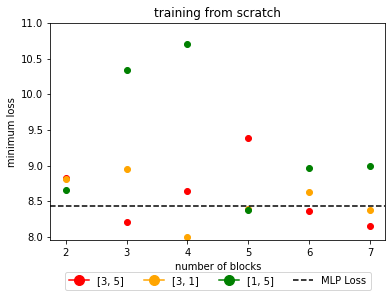

In [17]:
loss_data = np.array([[[10.146,8.827],[9.475,8.207],[8.650,8.775],[9.384,10.052],[13.571,8.369],[8.150,8.344]],
                      [[8.812,10.275],[11.119,8.953],[8.781,7.998],[8.506,8.390],[9.168,8.627],[9.968,8.374]],
                      [[11.572,8.653],[10.335,11.835],[10.709,14.582],[8.962,8.376],[9.523,8.965],[10.059,8.995]]])

colors = ["red", "orange", "green", "blue", "purple"]

plt.figure(figsize=(6,4))
plt.axhline(8.43, c="black", ls="--")
for i in range(6):
    for j in range(3):
        
        plt.scatter(i+2, min(loss_data[j,i,0], loss_data[j,i,1]), c=colors[j], marker="o")
        
legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='[3, 5]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[1], label='[3, 1]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[2], label='[1, 5]', markersize=10),
                   #Line2D([0], [0], marker='o', color=colors[3], label='[17, 5]', markersize=10),
                   Line2D([0], [0], ls="--", color="black", label="MLP Loss")]

plt.title("training from scratch")
plt.xlabel("number of blocks")
plt.ylabel("minimum loss")
plt.ylim(7.95, 11)

plt.legend(handles=legend_elements, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.25))

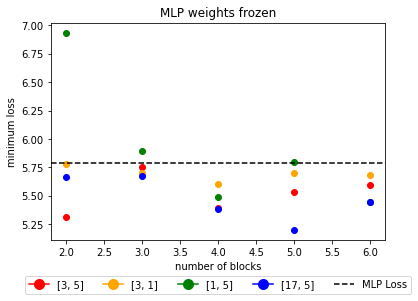

In [12]:
from matplotlib.lines import Line2D
loss_data = np.array([[[5.490, 5.315],[5.966, 5.750],[5.628, 5.390],[5.822, 5.534],[5.704,5.597]],
                      [[5.783, 5.804],[7.034, 5.697],[5.603, 6.405],[6.014, 5.698],[6.135,5.684]],
                      [[8.086, 6.937],[5.899, 5.892],[5.676, 5.493],[5.984, 5.794],[5.448,5.568]],
                      [[5.663, 5.768],[5.676, 5.827],[5.717, 5.385],[5.564, 5.197],[5.584, 5.444]]])

colors = ["red", "orange", "green", "blue", "purple"]

plt.figure(figsize=(6,4))
plt.axhline(5.79, c="black", ls="--")
for i in range(5):
    for j in range(4):
        
        plt.scatter(i+2, min(loss_data[j,i,0], loss_data[j,i,1]), c=colors[j], marker="o")
        
legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='[3, 5]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[1], label='[3, 1]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[2], label='[1, 5]', markersize=10),
                   Line2D([0], [0], marker='o', color=colors[3], label='[17, 5]', markersize=10),
                   Line2D([0], [0], ls="--", color="black", label="MLP Loss")]

plt.title("MLP weights frozen")
plt.xlabel("number of blocks")
plt.ylabel("minimum loss")
#plt.ylim(7.95, 11)

plt.legend(handles=legend_elements, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.27))